#**Linear Classifier in Tensorflow**

We are now going to go through the book's example of implementing a linear classifier from scratch using Tensorflow. We already demonstrated our procedure using Keras + Tensorflow, so this is just another example to reinforce understanding.

#*Simulate Data*

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # for cross tabulation to make confusion matrix.

# We will ultimately have 2000 observations, 1000 1's and 1000 0's. 
# We are drawing a two inputs (x's) which are jointly normal, taking on average values of 0 and 3 when the outcome is 0, and values of 3 and 0 when the outcome is 1. 
# The cov are covariance matrices, defining how the two x's associate with one another. 
num_samples_per_class = 1000 
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

# Now we stack the two vector pairs together into a single dataset. 
samples = np.vstack((negative_samples,positive_samples))

labels = np.vstack((np.zeros((1000,1)),np.ones((1000,1))))

Plotting the resultant data...

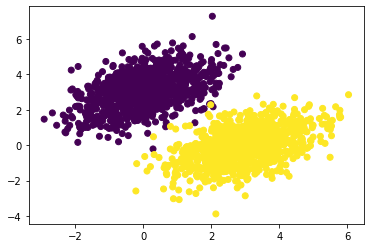

In [3]:
# We make a scatter plot of the first and second columns of the samples matrix (x1 and x2)
# The colors are assigned based on the target label for each observation.
plt.scatter(samples[:,0],samples[:,1],c=labels[:,0])
plt.show()

#*Define Data, Parameters, and Model*

In [4]:
# Our first layer is the two inputs, and then we have it mapping directly into an output layer, which yields a continuous prediction. 
# We will apply a threshold to the prediction to get our classification.
input_dim = 2
output_dim = 1

# Here we define matrix W and vector b, our weights and biases.
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

# This is just the w*x+b without an activation.
def model(inputs):
    return tf.matmul(inputs, W) + b

# We will use MSE loss: mean[(target-prediction)^2]
def square_loss(predictions,targets):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

# This is the scalar multiple we will apply against gradients for the updates.
learning_rate = 0.1 

# A single training step will take the input data, and the target labels.
# It performs a forward pass, calculates current loss, does the backward pass to get gradients...
# Finally, it updates W and b based on resulting gradients.
def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate) # assign_sub() subtracts the argument value from the current value in place. 
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

Now we can implement our linear classifier (note, in econometrics, we would call this a linear probability model). We first take our simulated data and declare it as tensors that Tensorflow can work with. Defining these as float32 because they were originally doubles. Need them to match datatype with the weight tensors. 

In [ ]:
data = tf.constant(samples,dtype="float32")
groundTruth = tf.constant(labels,dtype="float32")

for step in range(40):
    loss = training_step(data,groundTruth)
    print("Loss at step ",step,": ",loss.numpy(),sep="")

Now, we can pull out the predictions from the final fit model, and apply a threshold of 0.5 for the predictions (1 vs 0). 

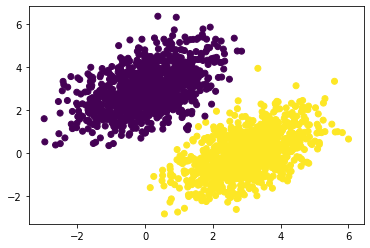

Actual,False,True
Predicted,,
False,999,5
True,1,995


In [ ]:
# It does a pretty good job. 
predictions = model(data)
plt.scatter(data[:, 0], data[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

confusionMatrix = pd.DataFrame({"Predicted":predictions[:,0]>0.5,"Actual":groundTruth[:,0].numpy().astype(np.bool)})
pd.crosstab(confusionMatrix['Predicted'],confusionMatrix['Actual'])

#**Again, using Keras, with Validation**

We are going to train the same classifier again. This time, however, we are going to use the Keras API to simplify things, and we will incorporate a holdout dataset for model evaluation. 

In [ ]:
from tensorflow import keras 
from tensorflow.keras import layers
  
model = keras.Sequential([
    layers.Dense(1, activation="linear")
])

model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["mean_squared_error"])

# Here we are taking the row indices of the data and scrambling their order.  
indices_permutation = np.random.permutation(len(samples))

# We are then using the result to shuffle the observations in our data.
shuffled_inputs = samples[indices_permutation]
shuffled_targets = labels[indices_permutation]
 
# Here we are saying that 30% of the data will be selected to serve as validation.
num_validation_samples = int(0.3 * len(inputs))

# Now we are pulling out the validation samples.
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]

# And here we are pulling out the training samples.
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

# Finally, when we call the fit function, we separately specify training data and validation data.
# We indicate the latter using the validation_data argument. 
history = model.fit(
    training_inputs,
    training_targets,
    epochs=30,
    batch_size=50,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/30
28/28 [==============================] - 0s 6ms/step - loss: 1.4539 - mean_squared_error: 1.4539 - val_loss: 1.4205 - val_mean_squared_error: 1.4205
Epoch 2/30
28/28 [==============================] - 0s 3ms/step - loss: 1.2536 - mean_squared_error: 1.2536 - val_loss: 1.2338 - val_mean_squared_error: 1.2338
Epoch 3/30
28/28 [==============================] - 0s 2ms/step - loss: 1.0837 - mean_squared_error: 1.0837 - val_loss: 1.0635 - val_mean_squared_error: 1.0635
Epoch 4/30
28/28 [==============================] - 0s 2ms/step - loss: 0.9296 - mean_squared_error: 0.9296 - val_loss: 0.9100 - val_mean_squared_error: 0.9100
Epoch 5/30
28/28 [==============================] - 0s 2ms/step - loss: 0.7914 - mean_squared_error: 0.7914 - val_loss: 0.7726 - val_mean_squared_error: 0.7726
Epoch 6/30
28/28 [==============================] - 0s 2ms/step - loss: 0.6688 - mean_squared_error: 0.6688 - val_loss: 0.6514 - val_mean_squared_error: 0.6514
Epoch 7/30
28/28 [======================

After the model fitting is complete, we call the evaluate function, and pass it the validation data. Note that batch size here is not the same batch size in the fit() call. Batch size here refers to batches of observations in validation data to run through (predictions and loss calculations)

5/5 [==============================] - 0s 3ms/step - loss: 0.0415 - mean_squared_error: 0.0415


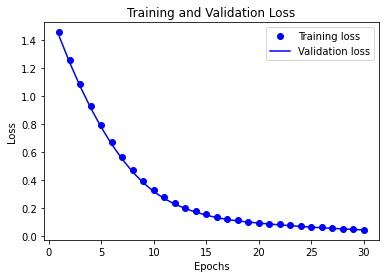

In [ ]:
loss_and_metrics = model.evaluate(val_inputs, val_targets, batch_size=128)

history_dict = history.history
history_dict.keys()

# Notice that there's basically no overfitting going on.
# Because there's no noise in the data for the network to fit to! 
trn_loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(trn_loss_values) + 1)
plt.plot(epochs, trn_loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()